# 熱伝達

$q_c = \alpha_c \cdot (\theta_s - \theta_f)$

* $q_c$ ... 対流による伝熱量 [$W/m^2$]
* $\alpha_c$ ... 熱伝達率 [$W/m^2\cdot K$]
* $\theta_s$ ... 個体壁表面温 [${}^\circ\mathrm{C}$]
* $\theta_f$ ... 壁体から十分離れた流体(空気)の温度 [${}^\circ\mathrm{C}$]

(最新建築環境工学 P.35, P.185)

In [1]:
#matplotlib inline

import matplotlib.pyplot as plt
import math


In [2]:
#計算単位時間 dt[s]

dt = 1

In [3]:
class LinkVariable:
    def __init__(self):
        self.Link = None
    
    def __call__(self, t):
        return self.Link(t)

class Kelvin:
    def __init__(self, V, cro, U, T):
        self.V = V      #容積[m^3]
        self.cro = cro  #[kJ/m^3・K]
        self.C = cro * 1000 * V  #熱容量[J/K]
        self.U = U
        self.T = T
    
    def __call__(self, t):
        return self.T
    
    def commit(self, t):
        self.T = self.T + self.U(t) / self.C

class ConvectiveHeatTransfer:
    def __init__(self, T1, T2, S,  c = 1.98, dt = 1.0):
        #c値
        #-----
        #暖房時の天井面または冷房時の床表面=2.67
        #暖房時の床表面または冷房時の天井面=0.64～0.87
        #垂直壁表面=1.98
        self.c = c
        
        self.T1 = T1
        self.T2 = T2
        self.S = S
        
        self.dt = dt
    
    def get_alpha_c(self, dT):
        return self.c * pow(dT, 0.25) 
    
    def get_U(self, t):
        dT = self.T1(t) - self.T2(t)
        alpha_c = self.get_alpha_c(dT)
        q = alpha_c * dT * self.dt
        U = q * self.S
        return U
    
    def __call__(self, tick):
        U = self.get_U(tick) * tick
        return -U

class HeatCapacityModule:
    def __init__(self, V, cro, T):
        self.U = LinkVariable()
        self.T = Kelvin(V, cro, self.U, T)
    
    def commit(self, t):
        self.T.commit(t)

class ConvectiveHeatTransferModule:
    def __init__(self, HC1, HC2, c = 1.98, dt = 1):
        self.CHT1 = ConvectiveHeatTransfer(HC1.T, HC2.T, c, dt)
        self.CHT2 = ConvectiveHeatTransfer(HC2.T, HC1.T, c, dt)
        HC1.U.Link = self.CHT1
        HC2.U.Link = self.CHT2
    
    def commit(self, t):
        return

class ContainerModule:
    def __init__(self):
        self.Modules = []
    
    def commit(self, t):
        for m in self.Modules:
            if m.commit:
                m.commit(t)

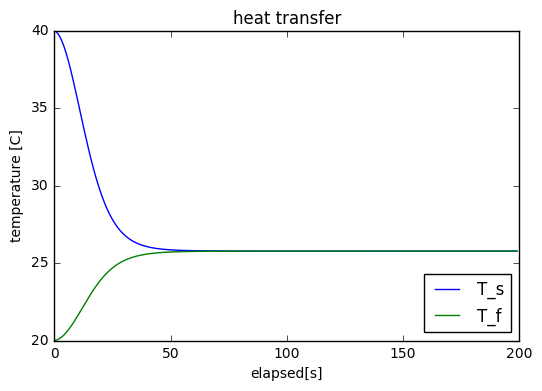

In [4]:
#計算単位時間 dt[s]
dt = 1

#壁(厚みは無視する)
wall = HeatCapacityModule(6 * 0.001, 854, 40)

#空気で見たされた部屋
room = HeatCapacityModule(10, 1.024 * 1.007, 20)

#自然換気対流
nv = ConvectiveHeatTransferModule(wall, room, 6, dt)

container = ContainerModule()
container.Modules.extend([wall, room, nv])

data = []
for i in range(200):
    
    container.commit(i)
    
    data.append((i*dt, wall.T(i), room.T(i)))

#表示
x = [x[0] for x in data]
plt.title("heat transfer")
plt.plot(x, [y[1] for y in data], label="$T_s$")
plt.plot(x, [y[2] for y in data], label="$T_f$")
#plt.ylim(0,50)
plt.xlabel("elapsed[s]")
plt.ylabel("temperature [C]")
plt.legend(loc="lower right")
plt.show()